In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os

from sklearn.model_selection import train_test_split

2024-03-28 15:18:34.684613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 15:18:34.684737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 15:18:34.816144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D ,Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Accuracy, MeanAbsoluteError
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau

In [3]:
class config:
    BATCH_SIZE = 64
    IMAGE_SIZE = 128
    seed = 42
    
cfg = config()

np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

In [4]:
d_path = "/kaggle/input/utkface-new/UTKFace"
image_paths = os.listdir(d_path)
np.random.shuffle(image_paths)

In [5]:
def getGenderAge(paths):
    genders = [int(path.split('_')[1]) for path in paths]
    age = [int(path.split('_')[0]) for path in paths]
    return genders, age

In [6]:
train_images, v_images = train_test_split(image_paths,train_size = 0.8, test_size = 0.2, random_state = cfg.seed)
val_images, test_images = train_test_split(v_images, train_size = 0.5, test_size = 0.5, random_state = cfg.seed)

In [7]:
print(f"training images: {len(train_images)}")
print(f"testing images: {len(val_images)}")
print(f"validation images: {len(test_images)}")

training images: 18966
testing images: 2371
validation images: 2371


In [8]:
train_genders, train_ages = getGenderAge(train_images)
val_genders, val_ages = getGenderAge(val_images)
test_genders, test_ages = getGenderAge(test_images)

In [9]:
class DG(Sequence):
    def __init__(self, image_filenames, gender_labels, age_labels, batch_size, img_width, img_height, augmentation = False,gender = True):
        self.image_filenames = image_filenames
        self.gender_labels = gender_labels
        self.age_labels = age_labels
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.augmentation = augmentation
        self.gender = gender
        
        if self.augmentation:
            # Define augmentation options
            self.datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))
    
    def preprocess_image(self,filename):
        filename = f"/kaggle/input/utkface-new/UTKFace/{filename}"
        img = load_img(filename, target_size=(self.img_width, self.img_height))
        img_array = img_to_array(img)
        img_array = np.reshape(img_array, (self.img_width, self.img_height, 3))
        return img_array
    
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_gender = self.gender_labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_age = self.age_labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Load and preprocess images
        images = [self.preprocess_image(filename) for filename in batch_x]
        
        images = np.array(images)
        images = next(self.datagen.flow(images, shuffle=False, batch_size=self.batch_size))
        if self.gender:
            return images, np.array(batch_y_gender,dtype=np.float32)
        else:
            return images, np.array(batch_y_age,dtype=np.float32)

In [10]:
gender_train_generator = DG(train_images,train_genders,train_ages,cfg.BATCH_SIZE,cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,True)
gender_val_generator = DG(val_images, val_genders, val_ages, cfg.BATCH_SIZE, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,False)
age_train_generator = DG(train_images,train_genders,train_ages,cfg.BATCH_SIZE,cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,True,False)
age_val_generator = DG(val_images, val_genders, val_ages, cfg.BATCH_SIZE, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,False,False)

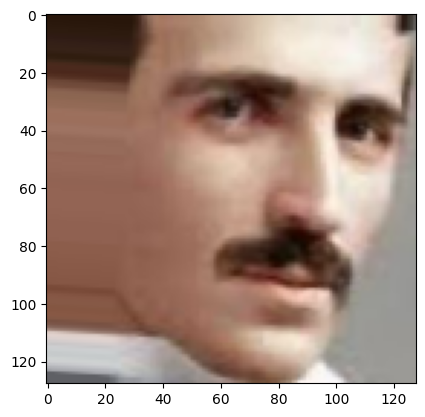

In [11]:
x = next(iter(gender_train_generator))
plt.imshow(x[0][11])
# x[1]

In [12]:
def get_gender_model(input_shape):
    inpt = Input(input_shape)
    conv = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    conv = conv(inpt)
    flt = GlobalAveragePooling2D()(conv)
    dense1 = Dense(256,activation = "relu")(flt)
    dense1 = Dropout(0.3)(dense1)
    dense2 = Dense(128,activation = "relu")(dense1)
    dense2 = Dropout(0.3)(dense2)
    dense3 = Dense(64,activation = "relu")(dense2)
    dense3 = Dropout(0.3)(dense3)
    dense4 = Dense(32,activation = "relu")(dense3)
    dense4 = Dropout(0.3)(dense4)
    gender = Dense(1, activation = "sigmoid", name = "gender_output")(dense4)
    model = Model(inputs = inpt, outputs = gender)
    
#     base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
    return model

def get_age_model(input_shape):
    inpt = Input(input_shape)
    conv = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    conv = conv(inpt)
    flt = GlobalAveragePooling2D()(conv)
    dense1 = Dense(512,activation = "relu")(flt)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(256,activation = "relu")(dense1)
    dense2 = Dropout(0.2)(dense2)
    dense3 = Dense(128,activation = "relu")(dense2)
    dense3 = Dropout(0.2)(dense3)
    age = Dense(1, activation = "linear",name = "age_output")(dense3)
    model = Model(inputs = inpt, outputs = age)
    
#     base_learning_rate = 0.0001
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),metrics=['mean_absolute_error'])
    return model

In [13]:
gender_model = get_gender_model((cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3))
age_model = get_age_model((cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
gender_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_output (Dense)           │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,185 (10.03 MB)

 Trainable params: 2,595,073 (9.90 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
age_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_output (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,209 (11.74 MB)

 Trainable params: 3,044,097 (11.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
mcg = ModelCheckpoint(mode='min',monitor='val_loss',filepath='topgender_weights.keras',verbose=1,save_best_only = True)
esg = EarlyStopping(mode='min', monitor='val_loss', patience=5, verbose=1)
reduce_lrg = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1) 
gender_callbacks = [mcg, esg,reduce_lrg]
mca = ModelCheckpoint(mode='min',monitor = 'val_loss',filepath='topage_weights.keras',verbose=1,save_best_only = True)
esa = EarlyStopping(mode='min', monitor='val_loss', patience=7, verbose=1)
reduce_lra = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1) 
age_callbacks = [mca, esa,reduce_lra]

In [17]:
history_gender = gender_model.fit(
    gender_train_generator,
    epochs = 30,
    validation_data = gender_val_generator,
    callbacks = gender_callbacks
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/297 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.4102 - loss: 0.9129   

I0000 00:00:1711639199.218685      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.7320 - loss: 0.5210
Epoch 1: val_loss improved from inf to 0.64135, saving model to topgender_weights.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 292s 764ms/step - accuracy: 0.7323 - loss: 0.5206 - val_accuracy: 0.8132 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8721 - loss: 0.3102
Epoch 2: val_loss did not improve from 0.64135
297/297 ━━━━━━━━━━━━━━━━━━━━ 91s 300ms/step - accuracy: 0.8721 - loss: 0.3102 - val_accuracy: 0.7094 - val_loss: 1.7074 - learning_rate: 0.0010
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8900 - loss: 0.2720
Epoch 3: val_loss did not improve from 0.64135
297/297 ━━━━━━━━━━━━━━━━━━━━ 92s 303ms/step - accuracy: 0.8900 - loss: 0.2719 - val_accuracy: 0.7895 - val_loss: 1.6631 - learning_rate: 0.0010
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8990 - loss: 0.2541
Epoch 4: val_loss did not improve from 0.641

In [18]:
history_age = age_model.fit(
    age_train_generator,
    epochs = 30,
    validation_data = age_val_generator,
    callbacks = age_callbacks
)

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 273.9422 - mean_absolute_error: 11.8649
Epoch 1: val_loss improved from inf to 4252.68262, saving model to topage_weights.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 184s 432ms/step - loss: 273.6416 - mean_absolute_error: 11.8583 - val_loss: 4252.6826 - val_mean_absolute_error: 63.0809 - learning_rate: 0.0010
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 131.8813 - mean_absolute_error: 8.3750
Epoch 2: val_loss improved from 4252.68262 to 521.91357, saving model to topage_weights.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 106s 344ms/step - loss: 131.8647 - mean_absolute_error: 8.3745 - val_loss: 521.9136 - val_mean_absolute_error: 20.4251 - learning_rate: 0.0010
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 110.5701 - mean_absolute_error: 7.6115
Epoch 3: val_loss did not improve from 521.91357
297/297 ━━━━━━━━━━━━━━━━━━━━ 102s 336ms/step - loss: 110.5586 - mean_absolute_error: 7.6111 - val_loss: 1539.2307 - val

In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
#     plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
#     plt.xlim([0,20])
    plt.legend()
    plt.grid(True)

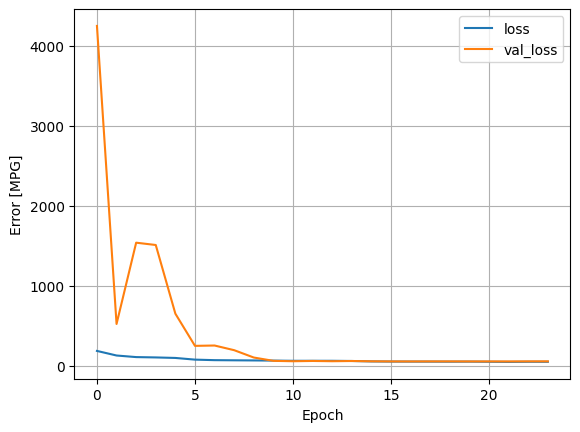

In [24]:
plot_loss(history_age)

In [27]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
#     plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

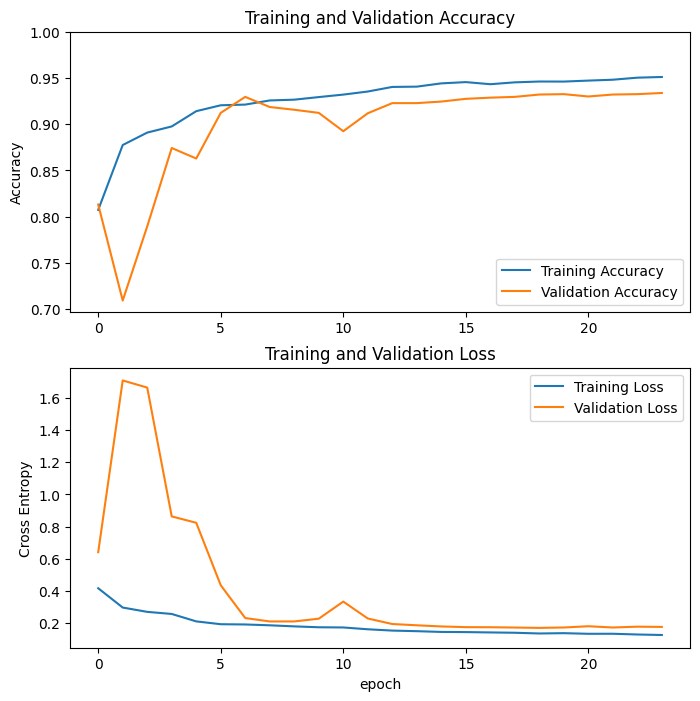

In [28]:
plot_hist(history_gender)

In [59]:
gender_test_generator = DG(test_images, test_genders, test_ages, cfg.BATCH_SIZE, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,False,True)
age_test_generator = DG(test_images,test_genders,test_ages,cfg.BATCH_SIZE,cfg.IMAGE_SIZE, cfg.IMAGE_SIZE,False,False)


In [60]:
gender_model.evaluate(gender_test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9341 - loss: 0.1737


[0.16574200987815857, 0.9316744208335876]

In [61]:
age_model.evaluate(age_test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 48.1983 - mean_absolute_error: 4.9132


[45.47496032714844, 4.832808971405029]

In [62]:
x = next(iter(age_val_generator))